In [1]:
# Carrega as variáveis de embiente usadas pelo notebook. Estas variáveis devem ser criadas no arquivo .env, localizada no mesmo diretório do notebook
# As seguintes variáveis devem ser criadas:
# - export STR_CON=<string de conexão com o banco de dados relacional>
# - export RAW_DATA_PATH=<caminho onde os arquivos contendo o histórico de preço de cada ativo será armazenado>
# - export DATASET_PATH=<caminho onde os arquivos contendo o histórico de preço e os indicadores técnicos serão armazenados>
# - export MODELS_PATH=<caminnho onde os modelos treinados serão armazenados>
# - export TRAIN_DATASET=<caminho onde os datasets estandarizados e formatados para o treinamento serão armazenados>
%load_ext dotenv
%dotenv

# Garante que os scripts Python sejam recarregados em cada execução do notebook.
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from data_preparation import PreProcess

preprocess = PreProcess()
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/train_data.parquet")
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

Y_Train = df_train.pop("label")
Y_Test = df_test.pop("label")

X_Train = np.array([val[0] for val in df_train.values])
X_Test = np.array([val[0] for val in df_test.values])


In [42]:
X_Train.shape

(56503, 45, 25)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 45, 32)            5376      
                                                                 
 lstm_6 (LSTM)               (None, 16)                3136      
                                                                 
 dense_18 (Dense)            (None, 128)               2176      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 32)               

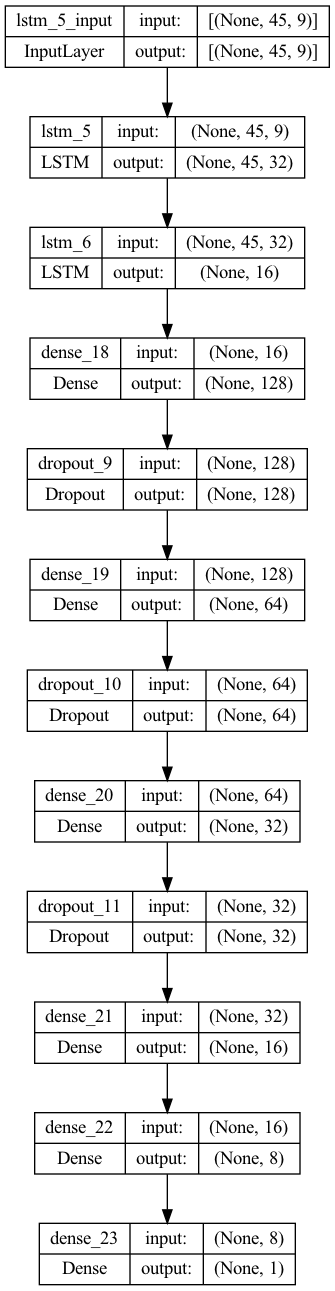

In [18]:
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.metrics import Recall, BinaryAccuracy, AUC, Accuracy
import tensorflow as tf
from keras.utils import plot_model


tf.get_logger().setLevel('INFO')
tf.debugging.set_log_device_placement(False)
metric = "accuracy"

early_stopping = EarlyStopping(monitor=f'val_{metric}', 
                               patience=20, 
                               min_delta=0.0005, 
                               mode='max')

cp_model_checkpoint = ModelCheckpoint("data/tf_models/benchmark/benchmark-{epoch:02d}-{val_accuracy:.4f}.h5",
                                      monitor=f'val_{metric}',
                                      save_best_only=True,
                                      verbose=1,
                                      mode="max")

cb_reduce_lr_on_plateu = ReduceLROnPlateau(monitor=f"val_{metric.lower()}",
                                            factor=0.1,
                                            patience=10,
                                            verbose=0,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr=0.0000001)

model = Sequential()
# model.add(Conv1D(name="conv1d_layer1",
#                  filters=32,
#                  kernel_size=(4),
#                  activation="relu"))
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Flatten(name="flatten",))
model.add(LSTM(32, input_shape=X_Train[0].shape, dropout=0.2, go_backwards=False, return_sequences=True))
model.add(LSTM(16, input_shape=X_Train[0].shape, dropout=0.2, go_backwards=False, return_sequences=False))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=[metric])
model.build(input_shape=X_Train.shape)
print(model.summary())
plot_model(model, 'images/lstm_basic.png', show_shapes=True)

In [19]:
batch_size = 32
epochs = 100

history = model.fit(X_Train, 
                    Y_Train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_Test, Y_Test), 
                    callbacks=[early_stopping, cp_model_checkpoint, cb_reduce_lr_on_plateu])#
                    
index = history.history[f'val_{metric}'].index(max(history.history[f'val_{metric}']))
max(history.history[f'val_{metric}'])#, history.history['val_recall'][index]

Epoch 1/100


2023-01-27 17:48:55.551031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:48:56.198772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:48:56.464195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:48:57.198749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:48:57.563114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1714/1714 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.6065

2023-01-27 17:52:13.383278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:52:13.636897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:52:13.899166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.60680, saving model to data/tf_models/benchmark/benchmark-01-0.6068.h5
1714/1714 [==============================] - 220s 124ms/step - loss: 0.6698 - accuracy: 0.6065 - val_loss: 0.6716 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 2/100
1714/1714 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.6068
Epoch 2: val_accuracy did not improve from 0.60680
1714/1714 [==============================] - 211s 123ms/step - loss: 0.6680 - accuracy: 0.6068 - val_loss: 0.6711 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 3/100
1714/1714 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.6068
Epoch 3: val_accuracy did not improve from 0.60680
1714/1714 [==============================] - 207s 121ms/step - loss: 0.6675 - accuracy: 0.6068 - val_loss: 0.6706 - val_accuracy: 0.6068 - lr: 0.0010
Epoch 4/100
1714/1714 [==============================] - ETA: 0s - loss: 0.6672 - accuracy: 0.6068
Epoch 4: val_accuracy did not imp

0.6161171197891235

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model
from data_preparation import PreProcess
import numpy as np

preprocess = PreProcess()
df_test = preprocess.read_dataset_from_parquet("data/train_dataset/indicadores_com_sinais/test_data.parquet")

X_TS_Test = np.array([val[0] for val in df_test.values])
Y_test = df_test.pop('label')
X_SIG_Test = df_test[df_test.columns[~df_test.columns.isin(['series'])]].values

model = load_model("/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/data/tf_models/benchmark/benchmark-01-0.6068.h5")

Y_test_predict = (model.predict([X_TS_Test]).flatten() > 0.5).astype(int)

print(f"Accuracy: {accuracy_score(Y_test.values, Y_test_predict):.4f}")
print("Matriz de confusao:\n", confusion_matrix(Y_test.values, Y_test_predict))
print(f"Precision: {precision_score(Y_test.values, Y_test_predict):.4f}")
print(f"Recall: {recall_score(Y_test.values, Y_test_predict):.4f}")
print(f"F1 Score: {f1_score(Y_test.values, Y_test_predict):.4f}")


# model.add(LSTM(32, input_shape=X_Train[0].shape, dropout=0.2,go_backwards=False, return_sequences=False))
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation="relu"))
# model.add(Dropout(0.2))
# model.add(Dense(16, activation="relu"))
# model.add(Dense(8, activation="relu"))
# model.add(Dense(1, activation='sigmoid'))
# Accuracy: 0.6178
# Matriz de confusao:
#  [[5755  171]
#  [3562  278]]
# Precision: 0.6192
# Recall: 0.0724
# F1 Score: 0.1296


2023-01-27 17:47:46.168552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:47:46.362449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-27 17:47:46.648328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


306/306 [==============================] - 16s 47ms/step
Accuracy: 0.6068
Matriz de confusao:
 [[5926    0]
 [3840    0]]
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/ricardomonteiro/pythonProjects/projects/proj_final_bimaster/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
df_train = preprocess.read_dataset_from_parquet("data/train_dataset/Sinais-com-historico/train_data.parquet")

df_train.iloc[:1000].groupby('label').count()/1000

,series
label,
0.0,0.642
1.0,0.358
